In [1]:
# Load the dataset and some utility functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.utils.data as utils
import torch.nn.functional as F
import torch.optim as optim
from pyro.distributions.torch import Normal
from pyro.distributions.torch import Categorical

import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


# If GPU is available set it to a GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import pyro
import matplotlib.pyplot as plt

In [5]:
normalize = transforms.Normalize((0.0,),(1/255.0,)) 
data_dir = "data/"

# Get TRAINING and VALIDATION datasets
# Define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
    ])
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=train_transform)

valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=valid_transform)

# Get 20% as a validation dataset
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1234)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=64, sampler=train_sampler, 
                num_workers=8)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler, 
                num_workers=8)

    # define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

test_dataset = datasets.MNIST(root=data_dir, 
                           train=False, 
                           download=True,
                           transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=32, 
                                        shuffle=True, 
                                        num_workers=8)

examples = enumerate(train_loader)
_, (image, label) = next(examples)

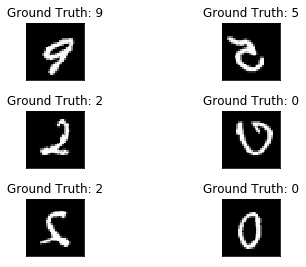

In [11]:
fig = plt.figure()
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.tight_layout()
    _, (image, label) = next(examples)
    i = np.random.randint(0,63)
    plt.imshow(torch.squeeze(image[i]), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(label[i].item()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Define a very simple model consisting of 4 inputs, 10 input nodes and 4 output nodes
class FCNet(torch.nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input = torch.nn.Linear(4, 10)
        self.output = torch.nn.Linear(10,4)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        return self.output(x)
    
net = FCNet()
net.to(DEVICE)

In [ ]:
# Define the PRIORS for the model that we have just defined
def model(x_data, y_data):
    # Define normal priors for INPUT layer
    inputw_prior = Normal(loc=torch.zeros_like(net.input.weight), scale=torch.ones_like(net.input.weight))
    inputb_prior = Normal(loc=torch.zeros_like(net.input.bias), scale=torch.ones_like(net.input.bias))
    
    # Define normal priors for OUTPUT layer
    outputw_prior = Normal(loc=torch.zeros_like(net.output.weight), scale=torch.ones_like(net.output.weight))
    outputb_prior = Normal(loc=torch.zeros_like(net.output.bias), scale=torch.ones_like(net.output.bias))
    
    # 
    priors = {'input.weight': inputw_prior, 'input.bias': inputb_prior,  'output.weight': outputw_prior, 'output.bias': outputb_prior}
    
    # Lift module parameters to 
    # random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    
    # Sample a regressor to sample w and b
    lifted_reg_model = lifted_module()
    
    # Pyro does not have an automatic activation depending on loss and given
    # That we want to do classification we need to use log softmax
    lhat = F.log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [ ]:
# This function is going to represent the POSTERIOR
# that we have just defined and which we are going try
# and approximate to the true posterior
def guide(x_data, y_data):
    # First layer weight distribution priors
    inputw_mu = torch.randn_like(net.input.weight)
    inputw_sigma = torch.randn_like(net.input.weight)
    inputw_mu_param = pyro.param("inputw_mu", inputw_mu)
    inputw_sigma_param = F.softplus(pyro.param("inputw_sigma", inputw_sigma))
    inputw_prior = Normal(loc=inputw_mu_param, scale=inputw_sigma_param)
    
    # First layer bias distribution priors
    inputb_mu = torch.randn_like(net.input.bias)
    inputb_sigma = torch.randn_like(net.input.bias)
    inputb_mu_param = pyro.param("inputb_mu", inputb_mu)
    inputb_sigma_param = F.softplus(pyro.param("inputb_sigma", inputb_sigma))
    inputb_prior = Normal(loc=inputb_mu_param, scale=inputb_sigma_param)
    
    # Output layer weight distribution priors
    outputw_mu = torch.randn_like(net.output.weight)
    outputw_sigma = torch.randn_like(net.output.weight)
    outputw_mu_param = pyro.param("outputw_mu", outputw_mu)
    outputw_sigma_param = F.softplus(pyro.param("outputw_sigma", outputw_sigma))
    outputw_prior = Normal(loc=outputw_mu_param, scale=outputw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outputb_mu = torch.randn_like(net.output.bias)
    outputb_sigma = torch.randn_like(net.output.bias)
    outputb_mu_param = pyro.param("outputb_mu", outputb_mu)
    outputb_sigma_param = F.softplus(pyro.param("outputb_sigma", outputb_sigma))
    outputb_prior = Normal(loc=outputb_mu_param, scale=outputb_sigma_param)
    
    priors = {'input.weight': inputw_prior, 'input.bias': inputb_prior, 'output.weight': outputw_prior, 'output.bias': outputb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [ ]:
# Define an optimiser in this case ADAM and we are going to use the double stochastic VI and maximise the ELBO
optim = pyro.optim.Adam({"lr": 0.1})
svi = pyro.infer.svi.SVI(model, guide, optim, loss=pyro.infer.trace_elbo.Trace_ELBO())

In [ ]:
# Since Bayesian NN functions thanks to sampling the models
# we need to sample the model several times to get several different estimates
# for the input data x 
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    std = torch.std(torch.stack(yhats), 0).numpy()
    mean = np.argmax(mean.numpy(), axis=1)
    std = np.array([std[i,mean[i]] for i in range(len(mean))])
    return mean, std

In [ ]:
# Just a utility function to calculate the accuracy
def accuracy(out, labels):
    return np.sum(out==labels)/float(labels.size)

In [ ]:
EPOCHS = 5

train_loss = []
val_loss = []

train_acc = []
val_acc = []

train_std = []
val_std = []

with torch.no_grad():
    t,t_std = predict(train_dataset.tensors[0])
    v,v_std = predict(val_dataset.tensors[0])
    t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
    v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
    val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
    train_std.append(np.mean(t_std))
    val_std.append(np.mean(v_std))
    print("Training accuracy: {0:.2f}".format(train_acc[-1]))
    print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

    # The main training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        loss = svi.step(inputs, labels)

        running_loss += loss
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0
            
    with torch.no_grad():
        t,t_std = predict(train_dataset.tensors[0].to(DEVICE))
        v,v_std = predict(val_dataset.tensors[0].to(DEVICE))
        t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
        v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
        val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
        train_std.append(t_std.mean())
        val_std.append(v_std.mean())
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))
        
print('Finished Training')
with torch.no_grad():
    t,t_std = predict(test_dataset.tensors[0])
    print("Test accuracy: {0:.2f}".format(accuracy(t,test_dataset.tensors[1].numpy())))


In [ ]:
# Plot the loss, accuracy as well as the standard deviation
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Validation Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_acc,linestyle='dashed',label="Train Accuracy")
ax2.plot(val_acc,linestyle='dashed',label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()

plt.title("Loss/Accuracy")
fig.tight_layout()

print(train_std,val_std)